<a id="1"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#5b81d4; overflow:hidden"><b> APTOS 2019 Blindness Detection </b></div>
<h2><center>Detect diabetic retinopathy to stop blindness before it's too late</center></h2>
<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/APTOS%202019%20Blindness%20Detection/aux_img.png"></center>

In this notebook, we address the urgent issue of diabetic retinopathy detection, a major cause of blindness among working-aged adults. Aravind Eye Hospital in India aims to improve healthcare access in rural areas, where technicians capture retinal images, but trained doctors are needed to manually review them. While effective, this method is time-consuming and limits scalability.

Our goal is to build a machine learning model that automates the detection of diabetic retinopathy, enabling faster and more accurate diagnoses. By leveraging state-of-the-art deep learning models, we aim to improve disease detection and expand this technology's potential to identify other conditions, like glaucoma and macular degeneration.

Models Utilized
We combine the strengths of multiple cutting-edge models for effective image classification:

**ResNetV2_50**: A deep convolutional network that specializes in feature extraction, allowing it to detect subtle features in retinal images with high precision.

**DeiT_base_patch16** (Vision Transformer): A transformer-based architecture that excels at capturing global dependencies within images, making it ideal for complex medical images.

**FastViT_s12**: A faster version of Vision Transformers, optimized for speed without sacrificing accuracy, ensuring quick inference times in real-time diagnostic settings.

**swinv2_small_window16_256**: A Shifted Window Transformer capable of handling images at multiple scales, providing fine-grained detail for more accurate detection of retinopathy.


- <a href="#libraries">1. Importing Required Libraries</a>
- <a href="#EDA">2. EDA</a>
- <a href="#Data Preprocssing">3. Data Preprecssing</a>
- <a href="#Transformation">4. Data Splitting and Transformation </a>
- <a href="#Tuning">5. Fine Tuning The Models </a>
    - <a href="#function">5.1. Train and validation function   </a> 
    - <a href="#Models">5.2. Fine tuning  swinv2_small_window16_256 </a> 
- <a href="#Evalution">6. Evalution</a>

<a id="libraries"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#5b81d4; overflow:hidden"><b> Importing Required Libraries </b></div>

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import timm
import random
import time
from collections import OrderedDict
from torch.cuda import amp
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.optim.optimizer
from torchvision import transforms as T
import matplotlib.pyplot as plt
from torchvision.io import read_image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns
from tqdm import tqdm
import concurrent.futures
from torch.utils.data import random_split
from sklearn.metrics import classification_report, f1_score

print(torch.__version__)

2.5.0+cpu


<a id="EDA"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#5b81d4; overflow:hidden"><b> EDA </b></div>

In [4]:
train= pd.read_csv('./train.csv')
test= pd.read_csv('./test.csv')

In [5]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

C:\Users\likhi\AppData\Local\Temp\ipykernel_11092\3771657651.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")


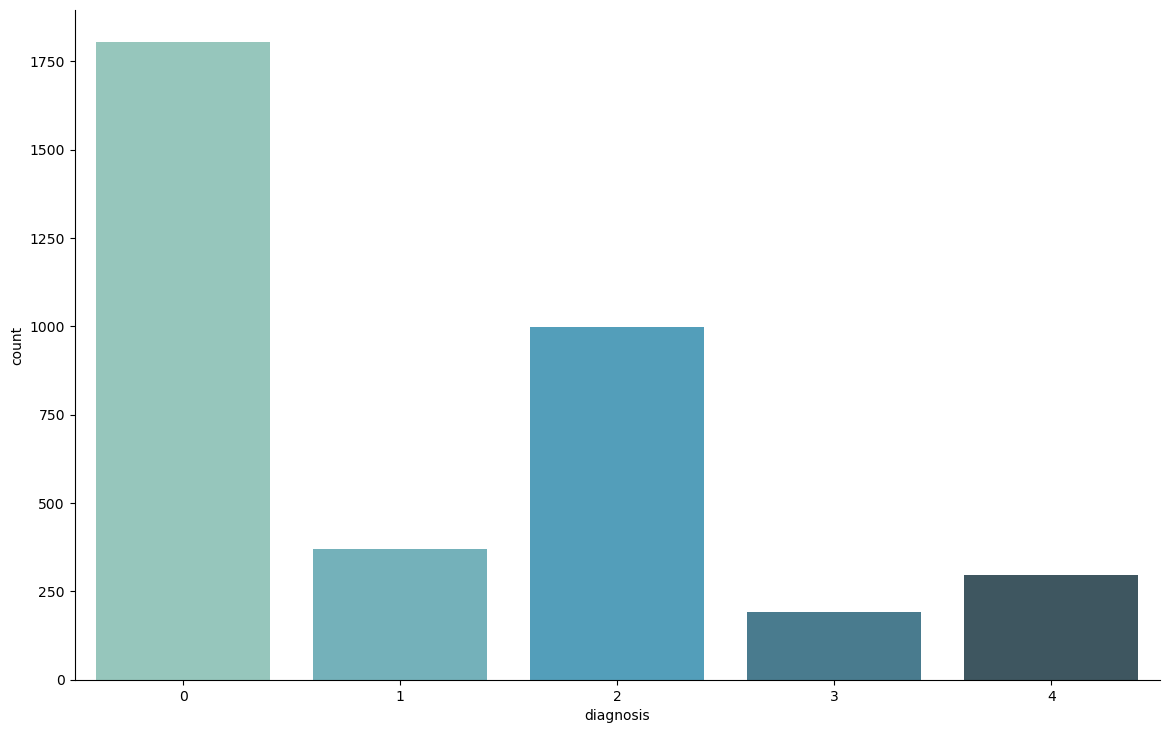

In [6]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")
sns.despine()
plt.show()

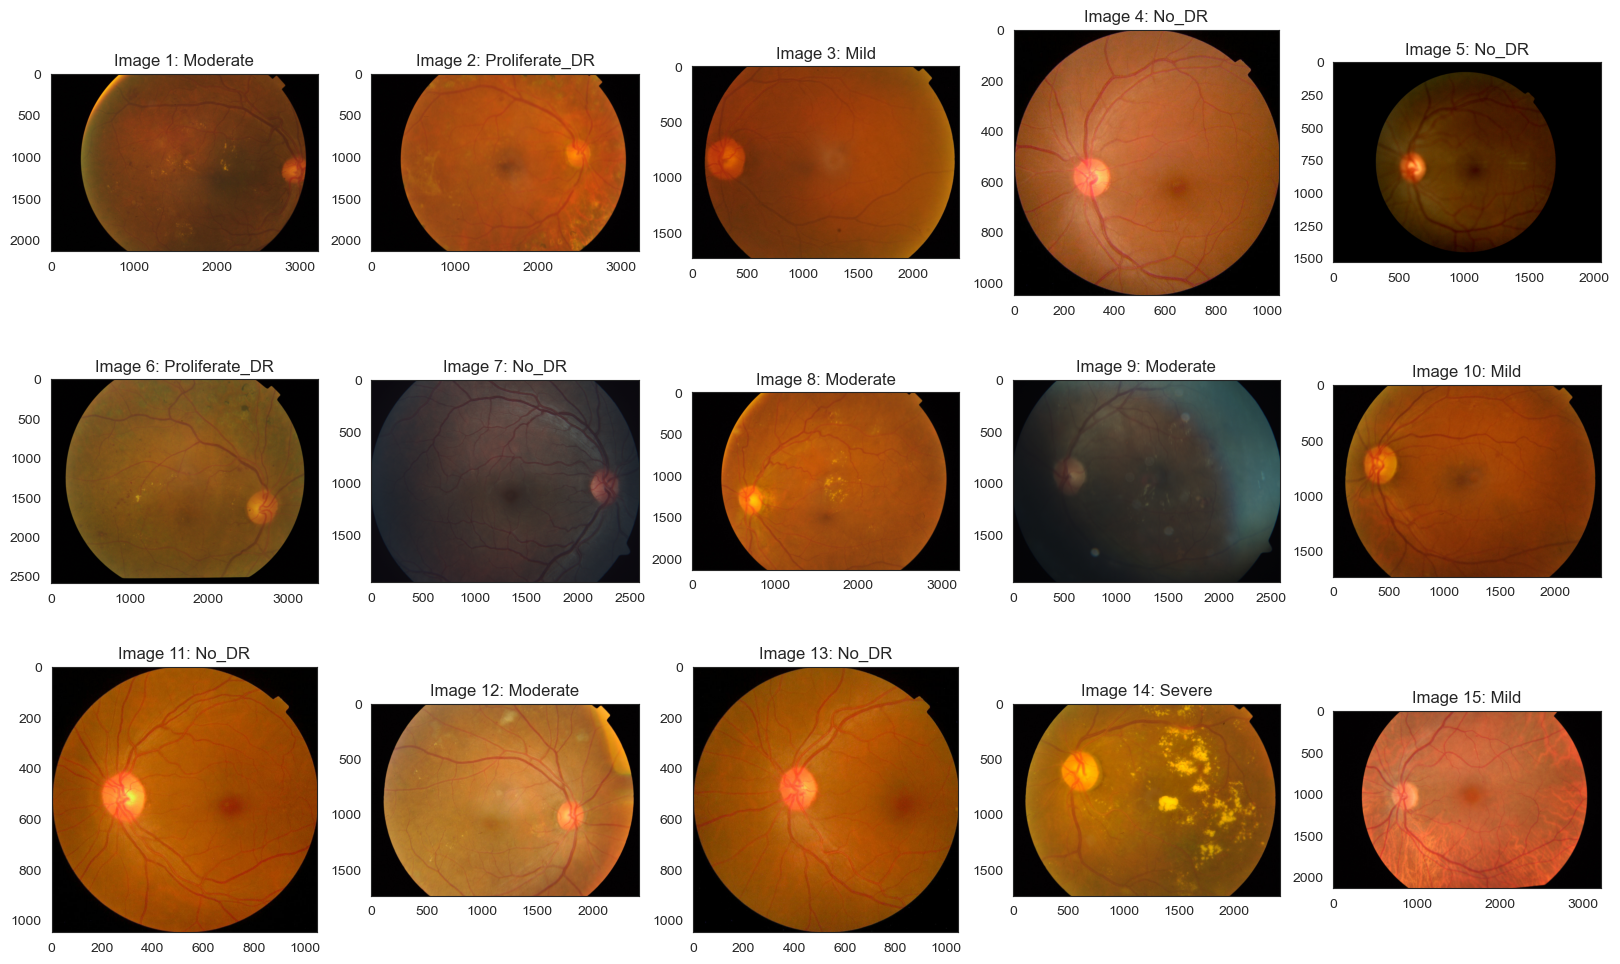

In [9]:
# Setting the style for the plot
sns.set_style("white")

# Mapping class labels to their corresponding categories
level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

# Plotting the first 15 images along with their labels
count = 1
plt.figure(figsize=[20, 20])

for img_name in train['id_code'][:15]:  # Assuming 'train' contains the dataset
    img = cv2.imread(f"./train_images/{img_name}.png")[..., [2, 1, 0]]  # Reading the image
    
    # Getting the label (class) for the image
    label = train[train['id_code'] == img_name]['diagnosis'].values[0]  # Assuming 'diagnosis' is the label column
    
    # Setting up the subplot with image and label
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title(f"Image {count}: {level_to_category[label]}")  # Display the class label
    count += 1
# Display the plot
plt.savefig('./imagebeforepreprecssing.png')
plt.show()


<a id="EDA"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#5b81d4; overflow:hidden"><b> Data Preprocessing </b></div>

In [10]:
# Function to crop the image based on grayscale threshold
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # Image is too dark so that we crop out everything
            return img  # Return original image
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

In [11]:
# Set input and output directories
input_dir = './train_images'
output_dir = './processed_images'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load the CSV containing image names and labels
csv_path = './train.csv'
df = pd.read_csv(csv_path)

# Create a CLAHE object
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Function to process a single image
def process_image(row):
    sample_image_id = row['id_code']  # Get the image ID
    sample_image_file = sample_image_id + '.png'  # Assuming the image files have .png extension
    sample_image_path = os.path.join(input_dir, sample_image_file)

    if os.path.exists(sample_image_path):
        # Load the image
        image = cv2.imread(sample_image_path)
        
        # Crop the image based on gray threshold
        image_cropped = crop_image_from_gray(image)
        
        # Resize the image to 256x256
        image_resized = cv2.resize(image_cropped, (256, 256))
        
        # Split the image into its channels (BGR format)
        blue, green, red = cv2.split(image_resized)
        
        # Apply CLAHE to all three channels
        blue_clahe = clahe.apply(blue)
        green_clahe = clahe.apply(green)
        red_clahe = clahe.apply(red)
        
        # Merge the CLAHE-enhanced channels back together
        result_image = cv2.merge([blue_clahe, green_clahe, red_clahe])
        
        # Save the processed image to the output directory
        output_path = os.path.join(output_dir, sample_image_file)
        cv2.imwrite(output_path, result_image)

# Using ThreadPoolExecutor to process images in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    # Using tqdm to show progress bar while processing images
    list(tqdm(executor.map(process_image, [row for _, row in df.iterrows()]), total=df.shape[0], desc="Processing images", unit="image"))

print("Processing complete for all images.")


Processing images: 100%|██████████| 3662/3662 [04:15<00:00, 14.31image/s]

Processing complete for all images.


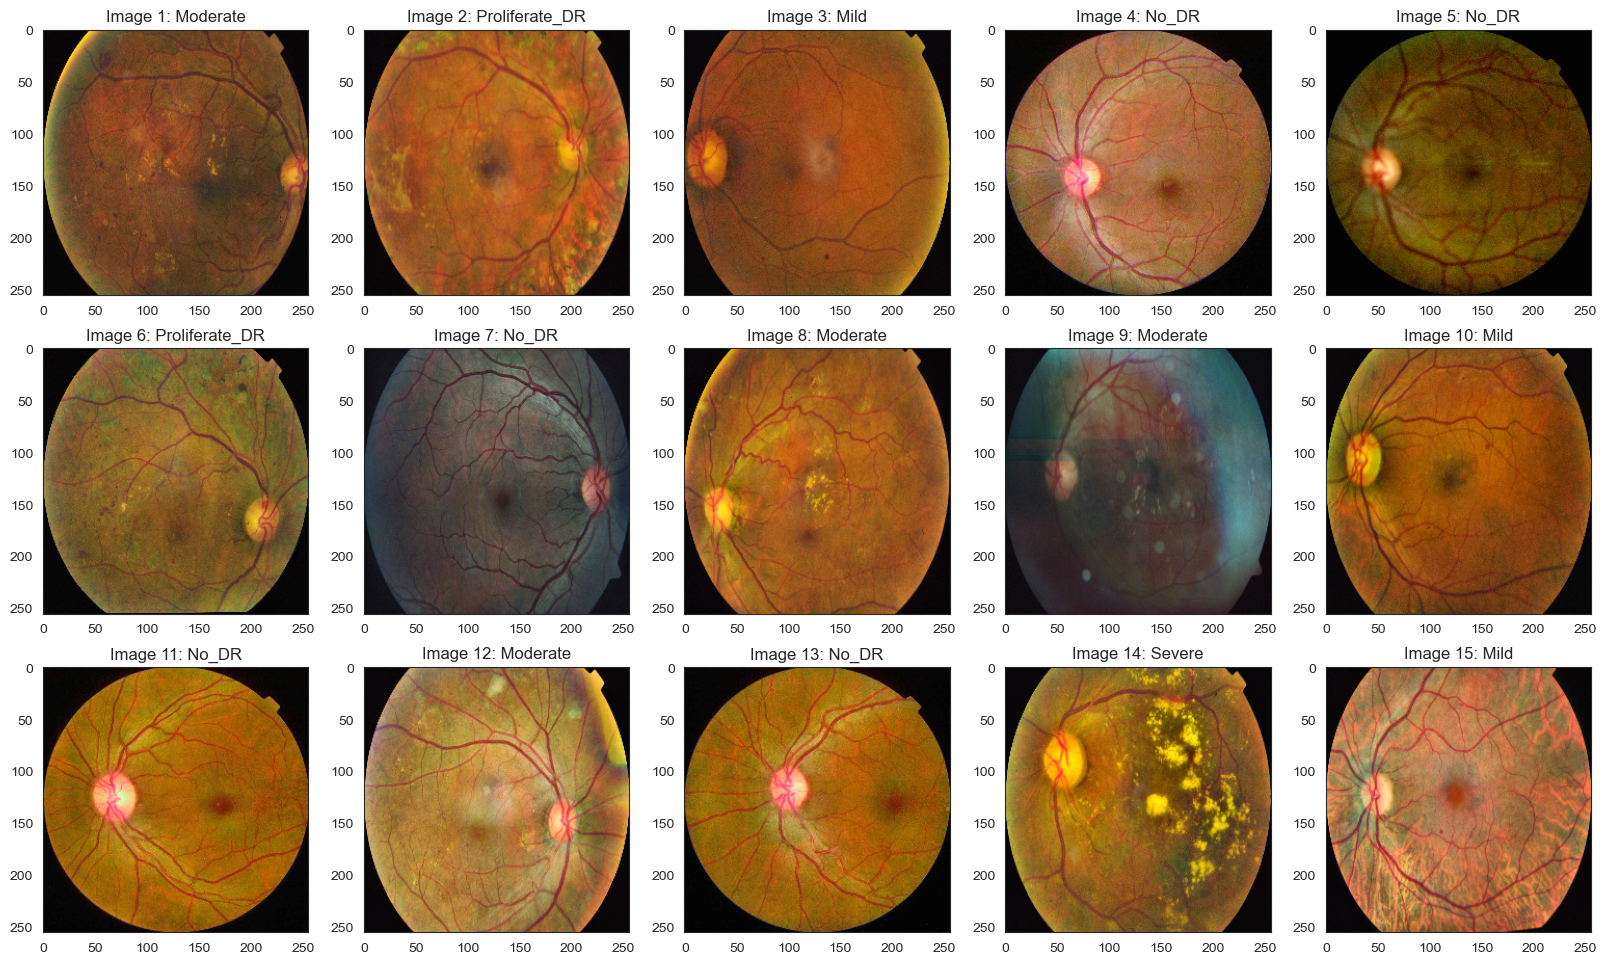

In [12]:
# Setting the style for the plot
sns.set_style("white")

# Mapping class labels to their corresponding categories
level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

# Plotting the first 15 images along with their labels
count = 1
plt.figure(figsize=[20, 20])

for img_name in train['id_code'][:15]:  # Assuming 'train' contains the dataset
    img = cv2.imread(f"./processed_images/{img_name}.png")[..., [2, 1, 0]]  # Reading the image
    
    # Getting the label (class) for the image
    label = train[train['id_code'] == img_name]['diagnosis'].values[0]  # Assuming 'diagnosis' is the label column
    
    # Setting up the subplot with image and label
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title(f"Image {count}: {level_to_category[label]}")  # Display the class label
    count += 1

# Display the plot
plt.show()


<a id="Transformation"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#5b81d4; overflow:hidden"><b> Data Splitting and Transformation </b></div>

In [13]:
DATA_DIR = "./processed_images"
TRAIN_DIR = "./processed_images"
CSV_PATH = "./train.csv"
MODEL_PATH = ".working"
LEARNING_RATE = 1e-4
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TRAIN_SPLIT = 0.8
NUM_WORKERS = 2
USE_AMP = True
EPOCHS=25

In [14]:
class RetinopathyDataset(Dataset):
    def __init__(self, image_dir, csv_file, transforms=None):
        self.data = pd.read_csv(csv_file)
        self.transforms = transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # img_name = os.path.join('../input/aptos2019-blindness-detection/train_images',
        #                         self.data.loc[idx, 'id_code'] + '.png')

        img_name = os.path.join(self.image_dir, self.data.loc[idx, 'id_code'] + '.png')

        tensor_image = read_image(img_name)
        label = torch.tensor(self.data.loc[idx, 'diagnosis'], dtype=torch.long)

        if self.transforms is not None:
            tensor_image = self.transforms(tensor_image)

        return (tensor_image, label)

In [15]:
train_trasforms_DeiT_base_patch16= T.Compose([
    T.ConvertImageDtype(torch.float32),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = RetinopathyDataset(TRAIN_DIR, CSV_PATH, transforms=train_trasforms_DeiT_base_patch16)

train_size = int(TRAIN_SPLIT * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(full_dataset, batch_size=TRAIN_BATCH_SIZE,
                          shuffle=False, num_workers=NUM_WORKERS, drop_last=True, pin_memory=False)

val_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, drop_last=True, pin_memory=False)

### Helper Functions and Utilities for Training and Evaluation

In [16]:
@torch.no_grad()
def accuracy(output, target):
    """
    Computes the overall accuracy of predictions.

    Args:
        output (torch.Tensor): Model predictions with shape (batch_size, num_classes).
        target (torch.Tensor): True labels with shape (batch_size,).

    Returns:
        float: Accuracy as a percentage.
    """
    with torch.no_grad():
        _, predicted = output.max(1)  # Get the class index with the highest score
        correct = predicted.eq(target).sum().item()  # Count correct predictions
        total = target.size(0)  # Total number of samples
        accuracy = 100.0 * correct / total  # Compute accuracy percentage

    return accuracy


def set_debug_apis(state: bool = False):
    """
    Configures PyTorch debugging tools.

    Args:
        state (bool): If True, enables debugging tools for profiling and anomaly detection.
    """
    torch.autograd.profiler.profile(enabled=state)
    torch.autograd.profiler.emit_nvtx(enabled=state)
    torch.autograd.set_detect_anomaly(mode=state)


def seed_everything(seed):
    """
    Sets seeds for reproducibility in training.

    Args:
        seed (int): Seed value to ensure determinism.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)  # Seed for hash-based operations
    np.random.seed(seed)  # Seed for NumPy
    torch.manual_seed(seed)  # Seed for PyTorch (CPU)
    torch.cuda.manual_seed(seed)  # Seed for PyTorch (GPU)
    torch.backends.cudnn.deterministic = True  # Make CuDNN deterministic
    torch.backends.cudnn.benchmark = True  # Enable benchmark mode for CuDNN


def print_size_of_model(model):
    """
    Calculates and prints the size of a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose size is to be calculated.
    """
    torch.save(model.state_dict(), "temp.p")  # Save model state
    print("Size (MB):", os.path.getsize("temp.p") / 1e6)  # Convert bytes to MB
    os.remove("temp.p")  # Clean up temporary file



In [17]:
print(torch.cuda.is_available())

False


<a id="Tuning"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#5b81d4; overflow:hidden"><b> Fine Tuning The Models </b></div>

<a id="function"></a>
### <div style="text-align:center; border-radius:15px; padding:5px; color:white; margin:0; font-size:100%; font-family:Arial; background-color:#f39c12;"><b>Training function and validations</b></div>


In [18]:
def train_step(model: torch.nn.Module, train_loader, criterion, device: str, optimizer, scheduler=None, num_batches: int = None, log_interval: int = 100, scaler=None):
    """
    Performs one step of training with progress tracking using tqdm, and updates progress at each epoch.
    """
    model = model.to(device)
    model.train()

    start_train_step = time.time()
    metrics = OrderedDict()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    # Initialize tqdm progress bar for the training loop (per epoch)
    with tqdm(train_loader, desc="Training", unit="batch") as pbar:
        for batch_idx, (inputs, target) in enumerate(pbar):
            inputs = inputs.to(device)
            target = target.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Mixed precision training if scaler is provided
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    output = model(inputs)
                    loss = criterion(output, target)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                output = model(inputs)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

            # Update the scheduler if it's provided
            if scheduler is not None:
                scheduler.step()

            # Update metrics
            total_loss += loss.item() * inputs.size(0)
            _, predicted = output.max(1)
            correct_predictions += predicted.eq(target).sum().item()
            total_samples += inputs.size(0)

            # Update progress bar (per batch)
            pbar.set_postfix({
                "Loss": f"{total_loss / total_samples:.4f}",
                "Accuracy": f"{100.0 * correct_predictions / total_samples:.2f}%"
            })

            # Break if num_batches is set and we've reached the limit
            if num_batches is not None and batch_idx + 1 >= num_batches:
                break

    # Final metrics for the epoch
    end_train_step = time.time()
    metrics["loss"] = total_loss / total_samples
    metrics["accuracy"] = 100.0 * correct_predictions / total_samples

    # Print the time taken for the train step and the summary of the metrics
    print(f"\nEpoch Summary: Time taken for train step = {end_train_step - start_train_step:.2f} sec")
    print(f"Training loss = {metrics['loss']:.4f}, Training accuracy = {metrics['accuracy']:.2f}%")

    return metrics

In [19]:
@torch.no_grad()  # No gradient calculation needed during validation
def val_step(model: torch.nn.Module, val_loader, criterion, device: str, num_batches=None, log_interval: int = 100):
    """
    Performs one step of validation with progress tracking using tqdm.

    Args:
        model: A PyTorch CNN Model.
        val_loader: DataLoader for the validation set.
        criterion: Loss function to evaluate.
        device: "cuda" or "cpu".
        num_batches: (optional) Limit validation to a certain number of batches.
        log_interval: (optional) Log after every specified number of batches.
    """
    
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    start_val_step = time.time()  # Track the start time of the validation step
    metrics = OrderedDict()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    # Initialize tqdm progress bar for the validation loop (per epoch)
    with tqdm(val_loader, desc="Validation", unit="batch") as pbar:
        for batch_idx, (inputs, target) in enumerate(pbar):
            inputs = inputs.to(device)
            target = target.to(device)

            # Forward pass (no gradient computation)
            output = model(inputs)
            loss = criterion(output, target)

            # Update metrics
            total_loss += loss.item() * inputs.size(0)
            _, predicted = output.max(1)  # Get predictions
            correct_predictions += predicted.eq(target).sum().item()  # Compare predictions with targets
            total_samples += inputs.size(0)

            # Update progress bar with the current loss and accuracy
            pbar.set_postfix({
                "Loss": f"{total_loss / total_samples:.4f}",
                "Accuracy": f"{100.0 * correct_predictions / total_samples:.2f}%"
            })

            # Break if num_batches is specified and we've reached the limit
            if num_batches is not None and batch_idx + 1 >= num_batches:
                break

    # Final metrics for the epoch
    end_val_step = time.time()  # Track the end time of the validation step
    metrics["loss"] = total_loss / total_samples
    metrics["accuracy"] = 100.0 * correct_predictions / total_samples

    # Print the time taken and the final validation metrics
    print(f"\nValidation Summary: Time taken for validation step = {end_val_step - start_val_step:.2f} sec")
    print(f"Validation loss = {metrics['loss']:.4f}, Validation accuracy = {metrics['accuracy']:.2f}%")

    return metrics



<a id="Models"></a>
### <div style="text-align:center; border-radius:15px; padding:5px; color:white; margin:0; font-size:100%; font-family:Arial; background-color:#f39c12;"><b> Fine Tuning  SWIN </b></div>


In [20]:

MODEL_NAME = "swinv2_small_window16_256"
MODEL_SAVE=  "./swinv2.Csv"
seed_everything(42)
set_debug_apis(False)

# Handle imbalnced Classes 

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [23]:
from sklearn.utils.class_weight import compute_class_weight
# Extract the class labels (diagnosis column)
class_labels = train['diagnosis'].values

# Compute class weights using sklearn
unique_classes = np.unique(class_labels)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=class_labels)

# Create a dictionary that maps class labels to their corresponding weights
class_weight_dict = {class_label: weight for class_label, weight in zip(unique_classes, class_weights)}

print("Class Weights:", class_weight_dict)


Class Weights: {0: 0.4057617728531856, 1: 1.9794594594594594, 2: 0.7331331331331331, 3: 3.7948186528497407, 4: 2.4827118644067796}


In [24]:
model= timm.create_model(MODEL_NAME, pretrained=True, num_classes=5)
weights_tensor = torch.tensor(list(class_weight_dict.values())).float()
criterion= nn.CrossEntropyLoss(weight=weights_tensor.to(device))
optimizer= optim.AdamW(model.parameters(), lr=LEARNING_RATE)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

if USE_AMP:
    from torch.cuda import amp
    scaler = amp.GradScaler()

model.safetensors:   0%|          | 0.00/204M [00:00<?, ?B/s]

c:\Users\likhi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\likhi\.cache\huggingface\hub\models--timm--swinv2_small_window16_256.ms_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\likhi\AppData\Local\Temp\ipykernel_11092\1414476660.py:13: FutureWarning: `torch.cuda.amp.GradSc

In [26]:
from tqdm import tqdm
import time
import torch
import pandas as pd

# Initialize lists to store metrics
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# Record start time
start_time = time.time()

# Total number of batches for training and validation
train_batches = len(train_loader)
val_batches = len(val_loader)

# Start epoch loop with tqdm tracking total iterations per epoch
for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    # Initialize tqdm for the training loop (track overall progress for the epoch)
    with tqdm(total=train_batches, desc=f"Training Epoch {epoch+1}", unit="batch") as pbar_train:
        # Perform training step
        train_metrics = train_step(model, train_loader, criterion, device, optimizer, scaler=scaler)
        train_loss.append(train_metrics["loss"])
        train_accuracy.append(train_metrics["accuracy"])

        # Update progress bar after training
        pbar_train.set_postfix({
            "Loss": f"{train_metrics['loss']:.4f}",
            "Accuracy": f"{train_metrics['accuracy']:.2f}%"
        })
        pbar_train.update(train_batches)  # Update progress bar to the total number of batches

    # Initialize tqdm for the validation loop (track overall progress for the epoch)
    with tqdm(total=val_batches, desc=f"Validation Epoch {epoch+1}", unit="batch") as pbar_val:
        # Perform validation step
        val_metrics = val_step(model, val_loader, criterion, device)
        val_loss.append(val_metrics["loss"])
        val_accuracy.append(val_metrics["accuracy"])

        # Update progress bar after validation
        pbar_val.set_postfix({
            "Loss": f"{val_metrics['loss']:.4f}",
            "Accuracy": f"{val_metrics['accuracy']:.2f}%"
        })
        pbar_val.update(val_batches)  # Update progress bar to the total number of batches

    # Print epoch summary (not per-batch)
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Training loss = {train_metrics['loss']:.4f}, Training accuracy = {train_metrics['accuracy']:.2f}%")
    print(f"Validation loss = {val_metrics['loss']:.4f}, Validation accuracy = {val_metrics['accuracy']:.2f}%")

    # Save model checkpoint
    checkpoint_path = f"{MODEL_NAME}_epoch_{epoch+1}.pt"
    torch.save(model.state_dict(), checkpoint_path)

# Record end time
end_time = time.time()

# Calculate total training time
total_time = end_time - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    "epoch": range(1, EPOCHS + 1),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
})

# Save the DataFrame to CSV
metrics_df.to_csv(MODEL_SAVE, index=False)
print("Training metrics saved to CSV.")


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25



Epochs:   0%|          | 0/25 [00:05<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 25340, 24804) exited unexpectedly

In [59]:
model.load_state_dict(torch.load('C:/Users/likhi/OneDrive/Desktop/pdfs/DRDetector/aptos2019/swinv2_small_window16_256_epoch_24.pt',map_location=torch.device('cpu')))
model.eval()
from torchvision import transforms,models

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img = Image.open('processed_images/fce93caa4758.png')
print(img)
img = transform(img).unsqueeze(0)
with torch.no_grad():
    # model.eval()
    output = model(img)
    _, predicted = torch.max(output, 1)
    print(predicted.item())


C:\Users\likhi\AppData\Local\Temp\ipykernel_11092\1357406121.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('C:/Users/likhi/OneDrive/De

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x2B50752B230>
4


<a id="Evalution"></a>
# <div style="text-align:center; border-radius:30px 30px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#5b81d4; overflow:hidden"><b>Evalution </b></div>

In [35]:
metrics_path = f"{MODEL_NAME}_metrics.csv"  # Path to metrics CSV
metrics_df = pd.read_csv(MODEL_SAVE)

# Set Seaborn style for better aesthetics
sns.set_theme(style="whitegrid")

# Create a figure for visualizations
plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
sns.lineplot(x='epoch', y='train_loss', data=metrics_df, label='Train Loss', color='blue')
sns.lineplot(x='epoch', y='val_loss', data=metrics_df, label='Validation Loss', color='orange')
plt.title("Training and Validation Loss per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 1, 2)
sns.lineplot(x='epoch', y='train_accuracy', data=metrics_df, label='Train Accuracy', color='green')
sns.lineplot(x='epoch', y='val_accuracy', data=metrics_df, label='Validation Accuracy', color='red')
plt.title("Training and Validation Accuracy per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()

# Adjust spacing between plots
plt.tight_layout()

# Save the visualization as a file (optional)
output_plot_path = f"{MODEL_NAME}_training_visualization.png"
plt.savefig(output_plot_path, dpi=300)
print(f"Visualization saved to {output_plot_path}")

# Show the plots
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './swinv2.Csv'

In [22]:
# Load your model from checkpoint
def load_model_from_checkpoint(checkpoint_path, model_class, device):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()  # Set to evaluation mode
    return model

In [23]:
# Predict on validation data
def predict_on_validation(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to compute gradients for validation
        for inputs, labels in val_loader:  # Assuming dataloader is a dictionary with 'val' key
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect true and predicted labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

In [24]:
# Define paths and device
checkpoint_path = "/kaggle/working/swinv2_small_window16_256_epoch_24.pt"
model_class=5
# Initialize and load the model (replace YourModel with your actual model class)
model = load_model_from_checkpoint(checkpoint_path, model_class, device)

# Assuming `dataloaders` is a dictionary with 'val' key containing the validation dataloader
# Predict on validation set
y_true, y_pred = predict_on_validation(model, val_loader, device)


/tmp/ipykernel_23/3995944402.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


In [25]:
# Generate Classification Report
report = classification_report(y_true, y_pred, digits=2)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       355
           1       0.97      1.00      0.99        72
           2       1.00      0.98      0.99       181
           3       0.93      1.00      0.96        37
           4       1.00      0.98      0.99        59

    accuracy                           0.99       704
   macro avg       0.98      0.99      0.99       704
weighted avg       0.99      0.99      0.99       704



In [26]:

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(cm.shape[0]), yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_Swin 98.png', bbox_inches='tight')
plt.show()


In [27]:
# Define the level-to-category mapping
level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

# Calculate errors per class (misclassifications)
class_errors = {}
num_classes = cm.shape[0]

for i in range(num_classes):
    total = np.sum(cm[i, :])  # Total number of instances of class i
    incorrect = total - cm[i, i]  # Misclassified instances of class i
    error_rate = incorrect / total if total != 0 else 0
    class_errors[level_to_category[i]] = round(error_rate, 4)  # Round error_rate and map to class name

# Print class errors
for class_name, error_rate in class_errors.items():
    print(f"Class {class_name}: Error Rate = {error_rate}")


Class No_DR: Error Rate = 0.0028
Class Mild: Error Rate = 0.0
Class Moderate: Error Rate = 0.0166
Class Severe: Error Rate = 0.0
Class Proliferate_DR: Error Rate = 0.0169


In [28]:
# Create a DataFrame for the error rates
error_data = pd.DataFrame(list(class_errors.items()), columns=['Class', 'Error Rate'])


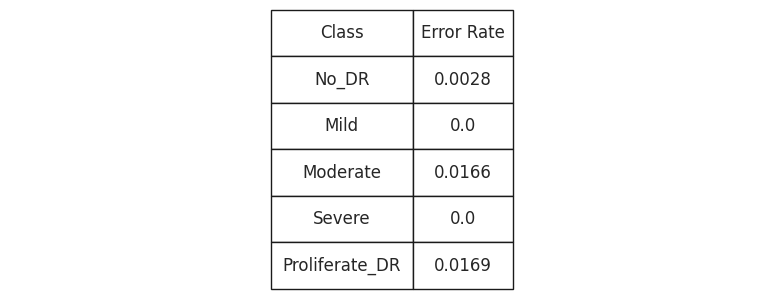

In [29]:
# Plot only the table, fitting the entire figure
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size as needed
ax.axis('off')  # Turn off axis for the table

# Create and display the table, making it fill the figure
table = ax.table(cellText=error_data.values, colLabels=error_data.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(error_data.columns))))
table.scale(20, 5)  # Scale table size (adjust the values as needed)
plt.savefig('Swin Table .png', bbox_inches='tight')

plt.tight_layout()
plt.show()


In [30]:
import torch
import cv2
import numpy as np
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# Define the preprocessing pipeline (same as during training)
train_transforms_DeiT_base_patch16 = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def process_external_image(image_path, transform=train_transforms_DeiT_base_patch16):
    """
    Process an external image to match the model's expected input format.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Crop, resize, and apply CLAHE preprocessing
    image_cropped = crop_image_from_gray(image)
    image_resized = cv2.resize(image_cropped, (256, 256))

    # Apply CLAHE enhancement (you can reuse the previous CLAHE code for this)
    blue, green, red = cv2.split(image_resized)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    blue_clahe = clahe.apply(blue)
    green_clahe = clahe.apply(green)
    red_clahe = clahe.apply(red)
    result_image = cv2.merge([blue_clahe, green_clahe, red_clahe])

    # Convert to PIL Image for transformation
    pil_image = Image.fromarray(result_image)

    # Apply the transform (normalization)
    image_tensor = transform(pil_image)

    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)
    
    return image_tensor

def predict_on_external_image(model, image_tensor, device):
    """
    Predict the class label of an external image using the trained model.
    """
    model.eval()  # Set model to evaluation mode
    image_tensor = image_tensor.to(device)  # Move the image tensor to the device (GPU or CPU)

    # Make prediction with the model
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_label = torch.max(output, 1)  # Get the predicted label
    
    return predicted_label.item()

# Example Usage:
image_path = "/kaggle/input/diabetic-retinopathy-resized/resized_train/resized_train/10003_left.jpeg"  # Replace with the path to the external image

# Process the external image
image_tensor = process_external_image(image_path)

# Predict the label
predicted_label = predict_on_external_image(model, image_tensor, device)

# Map the predicted label to category (based on your labels)
level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

# Print the predicted category
print(f"Predicted label: {level_to_category[predicted_label]}")

# Display the image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Predicted: {level_to_category[predicted_label]}")
plt.axis('off')  # Turn off axis
plt.show()


Predicted label: No_DR


# End

In [6]:
print("Done")

Done


In [ ]:
print("numpy version: ", np.__version__)
print("pandas version: ", pd.__version__)
print("torch version: ", torch.__version__)
print("seaborn version: ", sns.__version__)
print("timm version: ", timm.__version__)
print("PIL version: ", Image.__version__)
print("cv2 version: ", cv2.__version__) 
print("matplotlib version: ", plt.matplotlib.__version__)
print("sklearn version: ", sklearn.__version__)
print("tqdm version: ", tqdm.__version__)
print("concurrent.futures version: ", concurrent.futures.__version__)
print("torchvision version: ", torchvision.__version__)
print("transformers version: ", transformers.__version__)
print("torchtext version: ", torchtext.__version__)
print("torchsummary version: ", torchsummary.__version__)
print("torchmetrics version: ", torchmetrics.__version__)
print("torchinfo version: ", torchinfo.__version__)
print("torchviz version: ", torchviz.__version__)
print("torchtext version: ", torchtext.__version__)